In [3]:
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import pareto
from scipy.stats import lognorm
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline


To begin with, simulate the herfindhl for Pareto distribution. The foumulas are from Gabaix (2011).

$$h = \big[\sum_{i=1}^{N} (\frac{S_{it}}{Y_t})^2\big]^{0.5} $$
$$Y_t = \sum_{i=1}^{N} S_{it} $$

Except for $\zeta=1$, also assume that $\zeta$ is 1.059 following Axtell(2001).

In [5]:
σ_π = 0.12
a = 1
ζ = 1  # Zipf's law
x0 = a**(1/ζ)
N = 1000000
sim = 1000
eps = np.finfo(float).eps

In [6]:
@njit(parallel=True)
def herfindahl(nSim, ζ, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = (np.random.pareto(ζ, N) + 1) * x0         
        h[i] = np.sqrt(np.sum(np.square(size / np.sum(size))))

    return h    

for ζ in [1, 1+eps, 1.059]:
    h = herfindahl(nSim=1000, ζ=ζ)
    print(np.median(h))

0.12016512216161011
0.11324409397707055
0.07925165428441122


Then, if $\zeta$ is one, the herfindahl h is $12.0\%$. While if $\zeta$ is very closed to one but not one (one plus the smallest value in Python), the herfindahl is $11.3\%$

#### Match the mean and median provided that the log-normal distribution is cut off under some $ \bar{x}$.
Given the Pareto distribution with tail index $\zeta > 1$, the density function is
\begin{equation}
    f_P(x)=
    \begin{cases}
      \frac{\zeta {\bar{x}}^{\zeta}}{x^{\zeta+1}}, & \text{if}\ x\geq \bar{x} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}
Then, the corresponding mean and median are $\frac{\zeta \bar{x}}{\zeta-1}$ and $\bar{x} 2^{1/\zeta}$, respectively. The mean can be obtained by $\mathbb{E}(x)= \int x f_P(x) dx$ and the median is the root for $\frac{1}{2}=F_P(x)$ where $F_P(x)= 1-({\frac{x}{\bar{x}}})^{-\zeta}$ is the cumulative density function for $x \geq \bar{x}$.

If the log-normal distribution is $\ln(x) \sim \mathcal{N}(\mu, \,\sigma)$, then we can use the same approaches to find that its mean and median. The distribution for log-normal is
$$g(x) = \frac{1}{\sigma x \sqrt{2\pi}} \exp\{ {-\frac{(\ln{x-\mu})^2}{2\sigma^2}} \}.$$

Thus, from $\mathbb{E}(x)=\int g(x)dx$, the mean is $\exp(\mu + \frac{\sigma^2}{2})$. In addition, the CDF is $G(x) = \Phi(\frac{\ln(x)-\mu}{\sigma})$ where $\Phi(.)$ is the CDF for standard normel. Then, using $\frac{1}{2} = G(x)$, we know that $\frac{\ln(x)-\mu}{\sigma}=0$ and so the median is $\exp(\mu)$.

Now, we can try to match the log-normal with Pareto distribution under Zipf's law. Since the first moment is infinite when $\zeta=1$ for Pareto distribution, let $\zeta$ be very close to one but not one. Following the assumption for simulation in (Gabaix, 2011), assume $\bar{x}=1$. Then, fixing the mean and median of Pareto distribution (or fixing $\zeta$ and $\bar{x}$), if the mean and median for log-normal distribution are equal to those of Pareto distribution, we have

\begin{align*}\label{eq:1}
\text{mean} \quad & \frac{\zeta \bar{x}}{\zeta-1} = \exp(\mu + \frac{\sigma^2}{2}) \\
\text{median} \quad & \bar{x} 2^{1/\zeta} = \exp(\mu) \\ 
\end{align*}

Solve the equation of median given $\zeta$ and $\bar{x}$, we have $\mu = \ln(\bar{x} 2^{1/\zeta})$. Plug this into the mean equation, we can get $\sigma = (2 \ln(\frac{\zeta}{\zeta-1}) - \frac{2}{\zeta}\ln2)^{1/2}$.

##### Use the formula to sove $\mu$ and $\sigma$ numerically and plot the distribution.

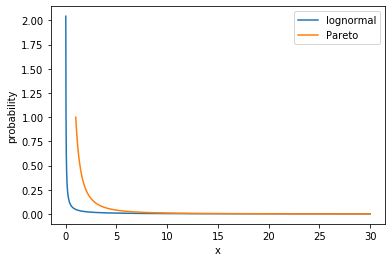

μ=0.69315, σ=8.40839


In [12]:
# Pareto pdf
ζ = 1 + np.finfo(float).eps  # under Zipf's law and the mean is finite
a = 1
f = lambda x: a*ζ / x**(ζ+1)

# lognormal pdf
σ = np.sqrt(2 * (np.log(ζ/(ζ-1)) - 1 / ζ * np.log(2)))
μ = np.log(2) / ζ
g = lambda x: 1/(x*σ*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-μ)**2 / (2*σ**2))

xd = np.linspace(1,30, 100000)
xd2 = np.linspace(0.02, 30, 100000)
plt.plot(xd2, g(xd2), label='lognormal')
plt.plot(xd, f(xd), label='Pareto')
plt.xlabel('x')
plt.ylabel('probability')
plt.legend()
plt.show()
print('μ=%1.5f, σ=%1.5f'%(μ, σ))

Simulate the herfindahl of log-normal for $\mu=0.69315$ and $\sigma=8.40839$. 

In [52]:
@njit(parallel=True)
def h_lognormal(nSim, mu, sigma, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = np.random.lognormal(mu, sigma, size=N)        
        mask=size>1
        h[i] = np.sqrt(np.sum(np.square(size[mask] / np.sum(size[mask]))))
    return h    


h = h_lognormal(nSim=1000, mu=0.69315, sigma=8.40839)
print(np.median(h))

0.5942463163571974


 $(\mu, \sigma)=(0.69315, 8.40839)$ are shape parameters for matched log-normal under Zipf's law($\zeta$ is close to one but not one). In this case, the herfindahl is 59.42% which is much higher than 12% of Pareto distribution. 
 
 When firm's growth rate is 12%, the deviation of growth rate $ \sigma_{GDP} = h\sigma $ is around 7.2% for log-normal which is also higher than 1.36% of Pareto ($11.3\% \times 12\%$). Since the empirically measured macroeconomic fluctuation is around 1%, the log-normal distribution is not reasonable under this matching.